# Cartpole Deep Q Learning Network    
    James McCarron - 201380393
    Harry Williams - 201374501   
## Library Imports
    These are the versions of the libraries we used.
    If the code won't run, check that your version match by running: pip show <packageName>
    
    Open AI Gym   0.12.1
    Numpy         1.16.2
    Keras         2.2.4
    Matplotlib    3.0.2

In [1]:
import random
import gym
import numpy as np
from numpy import ma
import turtle
import time

from collections import deque 
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

import os
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Parameters

     You can change the hyper-parameters here. 
     Choose Training mode or Testing mode
     Toggle Output Render

In [2]:
# GAME VERSION
v1  = True  
GAME = 'CartPole-v1' if v1 else 'CartPole-v0'
TARGET_SCORE = 194

# CREATE ENVIRONMENT
env = gym.make(GAME)

# SET TO TRUE IF RENDER REQUIRED
visible = False
    
# STATE PARAMETERS, ACTION PARAMETERS
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# HYPER PARAMETERS
BATCH_SIZE = 256           # Default is (20, 5000). (256, 100000) gets faster high scores.
MEMORY_LENGTH = 100000      # However, the tests take significantly longer.
GAMMA = 0.95
EPSILON_INIT = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.925
LEARNING_RATE = 0.0005
N_EPISODES = 500

# OUTPUT MANAGEMENT 
output_dir = 'model_output/cartpole'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print("State Size: {}\nAction Size: {}".format(state_size, action_size))

State Size: 4
Action Size: 2


## Define DQN Agent

In [3]:
# DEFINE THE STRUCTURE OF THE NEURAL NETWORK & INITIALISE PARAMETERS 
class DQNAgent:   
    def __init__(self,state_size,action_size):
        self.state_size  = state_size               # Number of variables that make up the state 
        self.action_size = action_size              # The number of actions our agent can take
        
        self.memory = deque(maxlen = MEMORY_LENGTH) # Experience Buffer      
        self.gamma = GAMMA                          # Discount future rewards
        
        self.epsilon = EPSILON_INIT                 # Exploration Probability at Start 
        self.epsilon_decay = EPSILON_DECAY          # How fast epsilon decreases
        self.epsilon_min = EPSILON_MIN              # Smallest allowable exploration
        
        self.learning_rate = LEARNING_RATE          # Coarseness of weight adjustment 
        self.model = self._build_model()
        
# BUILD THE NEURAL NETWORK         
    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim  = self.state_size, activation = 'relu')) # Input Layer
        model.add(Dense(24, activation = 'relu'))                               # Hidden Layer 
        model.add(Dense(self.action_size, activation = 'linear'))               # Output Layer 
        model.compile(loss = 'mse', optimizer = Adam(lr = self.learning_rate))  # Loss Function & Optimiser 
        
        return model
    
# RECORD THE EXPERIENCES     
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) 
        
# CHOOSE AN ACTION BASED ON E-GREEDY POLICY        
    def act(self, state):
        if np.random.rand() <= self.epsilon:           # If random number is less than or equal to epsilon
            return random.randrange(self.action_size)  # Choose a random action 
        act_values = self.model.predict(state)         # Else, update action values and choose greedy action 
        return np.argmax(act_values) 
        
# TRAIN THE NETWORK     
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0])) # Q-Learning Update
            target_f = self.model.predict(state) 
            target_f[0][action] = target
            
            self.model.fit(state,target_f, epochs = 1, verbose = 0)
            
# EPSILON DECAY
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
# MODEL I/O FUNCTIONS            
    def load(self, name):
        self.model.load_weights(name)
        
    def save(self, name):
        self.model.save_weights(name)   
        
    def saveGraph(self, name):
        self.model.save(name)

## Environment Interaction

In [4]:
# CREATE AGENT OBJECT 
agent = DQNAgent(state_size,action_size)

# OUTPUT ARRAYS 
scores  = []
epsilon = []

# MAIN TESTING LOOP
done = False 

for e in range(N_EPISODES):  
# INITIALISE STATE 
    state = env.reset() 
    state = np.reshape(state, [1, state_size])
    
# SET VISIBILITY     
    for time in range(5000): 
        if visible:
            env.render()
            
# CHOOSE ACTION & MAKE OBSERVATION
        action = agent.act(state) 
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10 # introduces a penalty for death
        next_state = np.reshape(next_state, [1, state_size])        
        agent.remember(state, action, reward, next_state, done)
        state = next_state 
        
        if done:
            print('Episode: {}/{}, Score: {}, Epsilon: {:.2}'.format(e + 1,N_EPISODES,time,agent.epsilon))
            scores.append(time)
            epsilon.append(agent.epsilon)
            break
            
    if len(agent.memory) > BATCH_SIZE:
        agent.replay(BATCH_SIZE)
        
# EVERY 50 RUNS, CREATE A FILE RECORDING THE NETWORK WEIGHTS   
    if e % 50 == 0:
        agent.save(output_dir + "weights_" + '{:04d}'.format(e) + ".hdf5") 

Episode: 1/500, Score: 10, Epsilon: 1.0
Episode: 2/500, Score: 20, Epsilon: 1.0
Episode: 3/500, Score: 19, Epsilon: 1.0
Episode: 4/500, Score: 14, Epsilon: 1.0
Episode: 5/500, Score: 25, Epsilon: 1.0
Episode: 6/500, Score: 28, Epsilon: 1.0
Episode: 7/500, Score: 15, Epsilon: 1.0
Episode: 8/500, Score: 15, Epsilon: 1.0
Episode: 9/500, Score: 34, Epsilon: 1.0
Episode: 10/500, Score: 10, Epsilon: 1.0
Episode: 11/500, Score: 16, Epsilon: 1.0
Episode: 12/500, Score: 37, Epsilon: 1.0
Episode: 13/500, Score: 13, Epsilon: 1.0
Episode: 14/500, Score: 8, Epsilon: 0.93
Episode: 15/500, Score: 21, Epsilon: 0.86
Episode: 16/500, Score: 11, Epsilon: 0.79
Episode: 17/500, Score: 11, Epsilon: 0.73
Episode: 18/500, Score: 11, Epsilon: 0.68
Episode: 19/500, Score: 18, Epsilon: 0.63
Episode: 20/500, Score: 20, Epsilon: 0.58
Episode: 21/500, Score: 12, Epsilon: 0.54
Episode: 22/500, Score: 12, Epsilon: 0.5
Episode: 23/500, Score: 12, Epsilon: 0.46
Episode: 24/500, Score: 15, Epsilon: 0.42
Episode: 25/500,

Episode: 187/500, Score: 499, Epsilon: 0.0093
Episode: 188/500, Score: 209, Epsilon: 0.0093
Episode: 189/500, Score: 233, Epsilon: 0.0093
Episode: 190/500, Score: 247, Epsilon: 0.0093
Episode: 191/500, Score: 360, Epsilon: 0.0093
Episode: 192/500, Score: 276, Epsilon: 0.0093
Episode: 193/500, Score: 429, Epsilon: 0.0093
Episode: 194/500, Score: 395, Epsilon: 0.0093
Episode: 195/500, Score: 267, Epsilon: 0.0093
Episode: 196/500, Score: 499, Epsilon: 0.0093
Episode: 197/500, Score: 170, Epsilon: 0.0093
Episode: 198/500, Score: 225, Epsilon: 0.0093
Episode: 199/500, Score: 406, Epsilon: 0.0093
Episode: 200/500, Score: 269, Epsilon: 0.0093
Episode: 201/500, Score: 201, Epsilon: 0.0093
Episode: 202/500, Score: 180, Epsilon: 0.0093
Episode: 203/500, Score: 177, Epsilon: 0.0093
Episode: 204/500, Score: 215, Epsilon: 0.0093
Episode: 205/500, Score: 225, Epsilon: 0.0093
Episode: 206/500, Score: 243, Epsilon: 0.0093
Episode: 207/500, Score: 237, Epsilon: 0.0093
Episode: 208/500, Score: 171, Epsi

Episode: 366/500, Score: 399, Epsilon: 0.0093
Episode: 367/500, Score: 248, Epsilon: 0.0093
Episode: 368/500, Score: 480, Epsilon: 0.0093
Episode: 369/500, Score: 195, Epsilon: 0.0093
Episode: 370/500, Score: 216, Epsilon: 0.0093
Episode: 371/500, Score: 382, Epsilon: 0.0093
Episode: 372/500, Score: 499, Epsilon: 0.0093
Episode: 373/500, Score: 499, Epsilon: 0.0093
Episode: 374/500, Score: 356, Epsilon: 0.0093
Episode: 375/500, Score: 499, Epsilon: 0.0093
Episode: 376/500, Score: 444, Epsilon: 0.0093
Episode: 377/500, Score: 199, Epsilon: 0.0093
Episode: 378/500, Score: 257, Epsilon: 0.0093
Episode: 379/500, Score: 229, Epsilon: 0.0093
Episode: 380/500, Score: 189, Epsilon: 0.0093
Episode: 381/500, Score: 229, Epsilon: 0.0093
Episode: 382/500, Score: 369, Epsilon: 0.0093
Episode: 383/500, Score: 234, Epsilon: 0.0093
Episode: 384/500, Score: 208, Epsilon: 0.0093
Episode: 385/500, Score: 176, Epsilon: 0.0093
Episode: 386/500, Score: 200, Epsilon: 0.0093
Episode: 387/500, Score: 157, Epsi

# Helper Functions

In [5]:
# RETURN A MOVING WINDOW AVERAGE. X = ARRAY, N = WINDOW SIZE 
def running_mean(x, N):
    sum = np.cumsum(np.insert(x, 0, 0)) 
    return (sum[N:] - sum[:-N]) / float(N)

In [6]:
# CALCULATES AND PRINTS THE OUTPUT STATS 
def print_info(scores, smooth_scores):    
    # OUTPUT ARRAYS 
    beaten_games = [] 
    beaten_games_rough = [] 
    
    # GET INDEX OF RUNS WHERE MOVING AVERAGE ABOVE TARGET SCORE
    i = 1
    for element in smooth_scores:
        if element >= TARGET_SCORE:
            beaten_games.append(i)
        i += 1
        
    # GET INDEX OF RUNS ABOVE TARGET_SCORE
    j = 1 
    for element in scores:
        if element >= TARGET_SCORE:
            beaten_games_rough.append(j)
        j += 1 
        
    # STATS CALCULATION
    beaten = False
    solved = False
    try:
        success_percentage = len(beaten_games_rough) / N_EPISODES * 100 
    except:
        print('The agent did not beat the game')
    else:
        beaten = True 
        
    try:
        solved_episode_number = beaten_games[0]
    except:
        print('The agent did not solve the game')
    else:
        solved = True
    
    # OUTPUT FORMATTING 
    if beaten:
        print('Wins: {} / {}\nSuccess Rate: {:2}%'.format(len(beaten_games_rough),N_EPISODES,success_percentage))
        print('First Win: {}'.format(beaten_games_rough[0]))
    if solved:
        print('Runs before solving: {}'.format(solved_episode_number))

## Matplotlib Graphs

    Outputs a number of useful graphs for visualising the data. 
        - Raw Score
        - Solved Score with threshold line. Remember, solved = avg of 195+ over 10 runs
        - Cumulative average

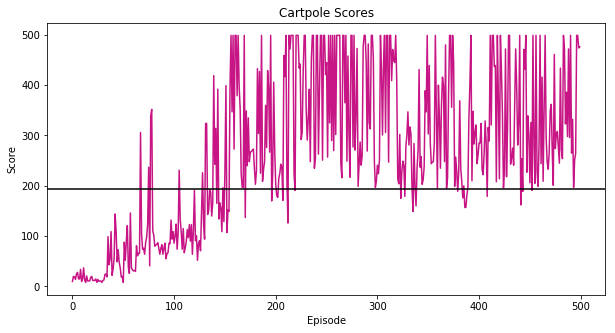

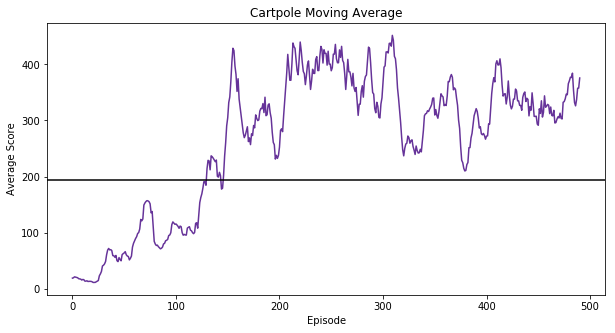

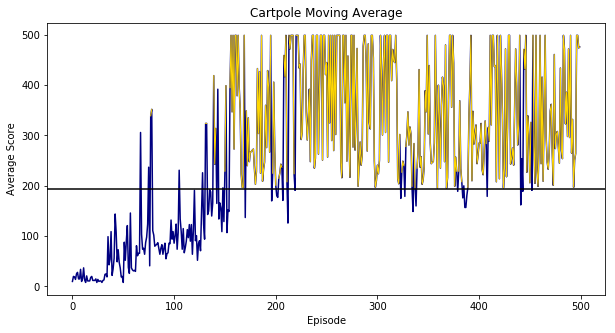

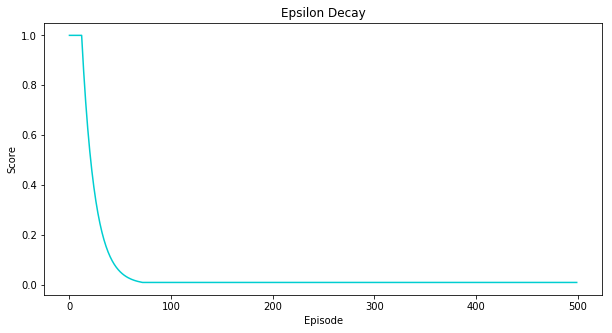

In [7]:
THRESHOLD_LINE_COLOR = 'Black'

# UNSMOOTHED SCORES 
plt.figure(figsize=(10,5)) 
plt.title('Cartpole Scores')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.plot(scores, color = 'mediumvioletred')
plt.axhline(y=TARGET_SCORE, color = THRESHOLD_LINE_COLOR) # THRESHOLD LINE
plt.show()

# MOVING AVERAGE (10) SCORES 
smooth_scores = running_mean(scores,10) 
plt.figure(figsize = (10, 5))
plt.title('Cartpole Moving Average')
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.plot(smooth_scores, color = 'rebeccapurple')
plt.axhline(y=TARGET_SCORE, color = THRESHOLD_LINE_COLOR) # Threshold Line 
plt.show()

# CUMULATIVE AVERAGE 
plt.figure(figsize = (10, 5))
plt.title('Cartpole Moving Average')
plt.xlabel('Episode')
plt.ylabel('Average Score')
v_smooth_scores = running_mean(scores,1)
mask = ma.masked_less(v_smooth_scores, TARGET_SCORE) # Get elements over threshold
plt.plot(v_smooth_scores, color = 'navy')            # Plot regular smoothed data
plt.plot(mask, color = 'gold', linewidth = 1)      # Plot elements over threshold in different color 
plt.axhline(y=TARGET_SCORE, color = THRESHOLD_LINE_COLOR) # Threshold Line 
plt.show()

# EPSILON DECAY GRAPH
plt.figure(figsize = (10, 5))
plt.title('Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.plot(epsilon, color = 'darkturquoise')    
plt.show()

## Run Statistics
In the Cartpole Environment, 'Solved' means acheiving an average score above the 97.5th percentile, over 10 consecutive runs.
In the Cartpole-V0 environment, the maximum score is 200. Therefore the target is to acheive on average 195+ over 10 consecutive runs. In the V1 version, the maximum score is 500
                
    Win    = Single run >= 195
    Solved = 10 point average >= 195

In [8]:
print_info(scores, smooth_scores)
average_score = np.average(scores)
print('Average Score:',average_score)

Wins: 340 / 500
Success Rate: 68.0%
First Win: 68
Runs before solving: 131
Average Score: 263.32
